In [1]:
import urllib
from sqlalchemy import create_engine
import pandas as pd
import datetime, time
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.anomaly import *

In [2]:
df_inve = pd.read_csv('input//inv_bal.csv')
sales = pd.read_csv('input//daily_sales.csv')
summary = pd.read_csv('input//summary.csv')

C:\Users\harry.yan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (229) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
inve = df_inve.copy()
summary = summary.iloc[:,:6]

In [4]:
inve = inve[['Company and Cost Centre','Product Category','SKU','RPT Sales and Margin Measure','Value']]

In [5]:
inve

,Company and Cost Centre,Product Category,SKU,RPT Sales and Margin Measure,Value
0,AULS.CNS102,12_ Phonecards,AULS100061,Stock Balance Qty,1.000000e+00
1,AULS.CNS102,12_ Phonecards,AULS100061,Stock Balance Amount,1.840000e+01
2,AULS.BNE202,11_ Cosmetics and HBA,AULS100080,Stock Balance Amount,-1.776357e-15
3,AULS.CNS102,11_ Cosmetics and HBA,AULS100080,Stock Balance Amount,-2.000000e-02
4,AULS.CBR101,11_ Cosmetics and HBA,AULS100080,Stock Balance Amount,-3.000000e-02
...,...,...,...,...,...
1149096,NZDF.QZN101,15_ Liquor,NZDF99461,Stock Balance Qty,2.700000e+01
1149097,NZDF.QZN101,15_ Liquor,NZDF99461,Stock Balance Amount,3.912141e+02
1149098,NZDF.QZN102,15_ Liquor,NZDF99461,Stock Balance Qty,2.700000e+01
1149099,NZDF.QZN102,15_ Liquor,NZDF99461,Stock Balance Amount,3.883160e+02


In [6]:
inve_pivot = inve.pivot_table(
    index = ['Company and Cost Centre','Product Category','SKU'],
    columns='RPT Sales and Margin Measure',
    values = 'Value',
    aggfunc = 'sum').reset_index()

In [7]:
inve_pivot = inve_pivot.round(0)

In [8]:
# inve_raw = inve_pivot[(inve_pivot['Stock Balance Amount'] >=1)&(inve_pivot['Stock Balance Qty']>0)]

In [9]:
inve_raw = inve_pivot[((inve_pivot['Stock Balance Amount'] >0)|(inve_pivot['Stock Balance Amount'] <0))&((inve_pivot['Stock Balance Qty']>0)|(inve_pivot['Stock Balance Qty']<0))]

In [10]:
inve_raw

RPT Sales and Margin Measure,Company and Cost Centre,Product Category,SKU,Stock Balance Amount,Stock Balance Qty
16,AUDF.ADL110,04_ Tobacco,AUDF100429846,29.0,30.0
17,AUDF.ADL110,04_ Tobacco,AUDF100429847,39.0,40.0
18,AUDF.ADL110,04_ Tobacco,AUDF100429848,33.0,14.0
37,AUDF.ADL110,04_ Tobacco,AUDF100540175,31.0,10.0
40,AUDF.ADL110,04_ Tobacco,AUDF100604660,14.0,3.0
...,...,...,...,...,...
876159,NZLS.WLG199,05_ Beverages,NZLS169923,41.0,24.0
876161,NZLS.WLG199,05_ Beverages,NZLS169925,41.0,24.0
876194,NZLS.WLG199,05_ Beverages,NZLS188709,65.0,48.0
876198,NZLS.WLG199,05_ Beverages,NZLS188956,154.0,96.0


In [11]:
data = inve_raw.merge(summary,on=['Company and Cost Centre','Product Category','SKU'],how='left')

In [12]:
data = data[data['Ave Qty Sold - L7D']>0]

In [13]:
data['days of inv'] = data['Stock Balance Qty'] / data['Ave Qty Sold - L7D']

In [14]:
def iforest(df):
    exp = setup(df[['days of inv', 'Stock Balance Amount']], silent = True, normalize = True)    
    knn = create_model(model = 'iforest', fraction = 0.05, verbose=False)
    result = predict_model(knn, data=df)
    return result

In [15]:
negative_value = (data['Stock Balance Amount']<0)|(data['Stock Balance Qty']<0)|(data['Ave Qty Sold - L7D']<0)
others = [not i for i in (data['Stock Balance Amount']<0)|(data['Stock Balance Qty']<0)|(data['Ave Qty Sold - L7D']<0)]

In [16]:
temp = []
for i, df in data[others].groupby('Product Category'):
    try:
        result = iforest(df)
        temp.append(result)
    except ValueError:
        pass

In [17]:
temp.append(data[negative_value])
result = pd.concat(temp)

In [18]:
result

,Company and Cost Centre,Product Category,SKU,Stock Balance Amount,Stock Balance Qty,Ave Qty Sold - L14D,Ave Qty Sold - L7D,Ave Qty Sold - L3D,days of inv,Label,Score
45740,AULS.ADL102,03_ Books,AULS305379,15.0,6.0,0.071429,0.142857,0.0,42.0,0.0,-0.131570
45766,AULS.ADL102,03_ Books,AULS305408,5.0,2.0,0.071429,0.142857,0.0,14.0,0.0,-0.148440
45787,AULS.ADL102,03_ Books,AULS313398,12.0,2.0,0.071429,0.142857,0.0,14.0,0.0,-0.188736
45794,AULS.ADL102,03_ Books,AULS313421,5.0,1.0,0.071429,0.142857,0.0,7.0,0.0,-0.159240
45806,AULS.ADL102,03_ Books,AULS328354,5.0,1.0,0.071429,0.142857,0.0,7.0,0.0,-0.159240
...,...,...,...,...,...,...,...,...,...,...,...
263340,NZLS.WLG101,08_ Access and Stationery,NZLS107122,-5.0,-2.0,0.285714,0.142857,0.0,-14.0,NaN,NaN
263904,NZLS.WLG101,10_ Gifts and Souvenirs,NZLS171615,-2.0,-1.0,0.071429,0.142857,0.0,-7.0,NaN,NaN
264111,NZLS.WLG101,10_ Gifts and Souvenirs,NZLS184058,-7.0,-1.0,0.142857,0.142857,0.0,-7.0,NaN,NaN
264115,NZLS.WLG101,10_ Gifts and Souvenirs,NZLS184065,-24.0,-3.0,0.071429,0.142857,0.0,-21.0,NaN,NaN


In [19]:
result['Product Category'].unique()

array(['03_ Books', '04_ Tobacco', '05_ Beverages', '06_ Confectionery',
       '07_ Travel accessories', '08_ Access and Stationery',
       '09_ Apparel', '10_ Gifts and Souvenirs', '11_ Cosmetics and HBA',
       '13_ Electronics', '15_ Liquor', '16_ Art of living',
       '18_ Fragrance'], dtype=object)

In [20]:
bev = result[result['Product Category'] == '11_ Cosmetics and HBA']

In [21]:
a = (bev['SKU'] == 'AULS512578')
b = [not i for i in a]

In [22]:
k = bev[a]
k['Label'] = 2
bev = k.append(bev[b])

In [23]:
# bev = bev[bev['days of inv'] < 10000]

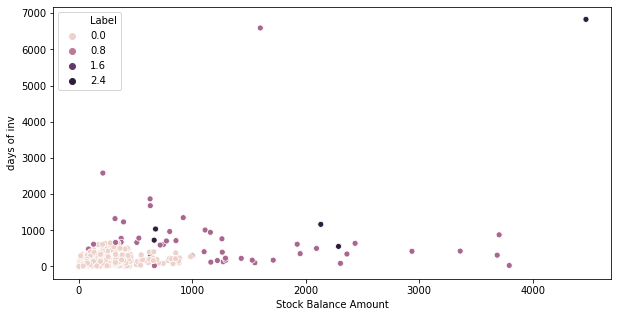

In [24]:
fig = plt.figure(figsize= (10,5))
sns.scatterplot(x = bev['Stock Balance Amount'], y = bev['days of inv'], hue = bev['Label'])
plt.show()

In [25]:
negative_value = (result['Stock Balance Amount']<0)|(result['Stock Balance Qty']<0)|(result['Ave Qty Sold - L7D']<0)
others = [not i for i in (result['Stock Balance Amount']<0)|(result['Stock Balance Qty']<0)|(result['Ave Qty Sold - L7D']<0)]

In [26]:
temp = result[negative_value]
temp['Label'] = -1
output = temp.append(result[others])

In [27]:
confec = output[output['Product Category'] == '06_ Confectionery']

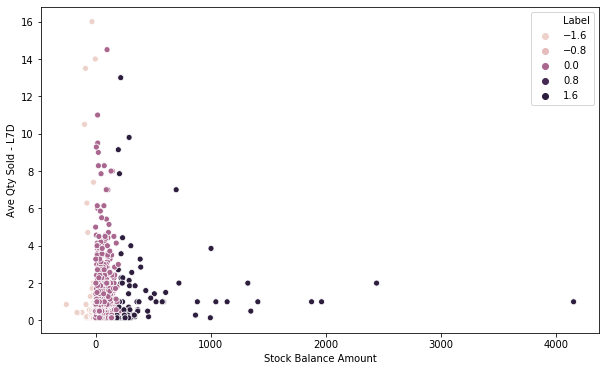

In [28]:
fig = plt.figure(figsize=(10,6))
sns.scatterplot(x = confec['Stock Balance Amount'],y=confec['Ave Qty Sold - L7D'], hue = confec['Label'])
plt.show()

In [29]:
output.to_csv('C://Users//harry.yan//Desktop//Inventory Anomaly//input//input.csv', index = False)

In [30]:
# # get location and item dimention from server
# import pandas as pd
# import numpy as np
# import pyodbc 
# # ------------------------------------------------------------------------------
# server = 'aupacpaassqlcomp2.81cc778a8dec.database.windows.net;' 
# database1 = 'aupacpaassqlcomp2da;' 
# database2 = 'aupacpaassqlcomp2ods;' # ReadOnly

# # Connect to the server-database
# user = 'h.yan@lagardere-traspac.com'

# conn = pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
#                       "Server=aupacpaassqlcomp2.81cc778a8dec.database.windows.net;"
#                       "Database=aupacpaassqlcomp2ods;"
#                       "Authentication=ActiveDirectoryInteractive;"
#                       "UID="+user+";")
# # ============================== Data Query ====================================
# # Specify SQL Script 
# sql_store = """SELECT TOP (1000) [CompanyCode]
#       ,[No]
#       ,[Name]
#       ,[Address]
#       ,[Address2]
#       ,[City]
#       ,[PostCode]
#       ,[PhoneNo]
#       ,[CountryCode]
#       ,[ResponsibilityCenter]
#       ,[GlobalDimension1Code]
#       ,[LocationCode]
#       ,[LastDateModified]
#       ,[StoreGenBusPostGr]
#       ,[EmailAddress]
#       ,[StoreVATBusPostGr]
#       ,[Class]
#       ,[LocationType]
#       ,[PricingRange]
#       ,[Region]
#       ,[PreOrdersActive]
#       ,[BoardingPassMandatory]
#       ,[BoardingPassEditable]
#       ,[PassportNoMandatory]
#       ,[EnableGIVEX]
#       ,[DisableEFTSurcharge]
#       ,[SurchargeTender]
#       ,[LastUpdateDateTime]
#   FROM [aupacpaassqlcomp2ods].[dbo].[vw_t_Store]""" 
# sql_item = """SELECT [CompanyCode]
#       ,[No]
#       ,[Description]
#       ,[DivisionCode]
#       ,[ItemCategoryCode]
#       ,[ProductGroupCode]
#       ,[SubGroup]
#       ,[InventoryPostingGroup]
#       ,[GenProdPostingGroup]
#       ,[VendorNo]
#   FROM [aupacpaassqlcomp2ods].[dbo].[vw_t_Item]"""

# # Execute SQL script and parse the data into a DataFrame
# store_info = pd.read_sql(sql_store,conn)
# item_info = pd.read_sql(sql_item,conn)

In [31]:
# store_info = store_info[['CompanyCode','No','City','CountryCode','Region']]
# store_info['Company and Cost Centre'] = store_info['CompanyCode'] + "." + store_info['No']
# store_info.to_csv('C://Users//harry.yan//Desktop//Inventory Anomaly//input//store_dim.csv', index = False)

In [32]:
df_inve[['Company and Cost Centre','Cluster','City']].drop_duplicates().to_csv('C://Users//harry.yan//Desktop//Inventory Anomaly//input//store_dim.csv', index = False)

In [33]:
# item_info = item_info[['CompanyCode','No','Description','ProductGroupCode']]

NameError: name 'item_info' is not defined

In [ ]:
# item_info['SKU'] = item_info['CompanyCode'] +  item_info['No']

In [34]:
# item_dim = pd.DataFrame(output.apply(lambda x: x['SKU'].split('-')[0], axis =1), columns=['SKU']).merge(item_info,on='SKU',how='left')

NameError: name 'item_info' is not defined

In [ ]:
# item_dim['SKU'] =list(output['SKU'])

In [ ]:
# item_dim.drop_duplicates().to_csv('C://Users//harry.yan//Desktop//Inventory Anomaly//input//item_dim.csv', index = False)

In [35]:
result['Unit Cost'] = result.apply(lambda x: x['Stock Balance Amount'] / x['Stock Balance Qty'] if x['Stock Balance Qty'] !=0 else 0, axis = 1)

In [36]:
result['Ave Cogs - L7D'] = result['Unit Cost'] * result['Ave Qty Sold - L7D']

In [37]:
store_rlt = result.groupby(['Company and Cost Centre','Product Category']).sum().reset_index()[['Company and Cost Centre','Product Category','Stock Balance Amount','Ave Cogs - L7D']]

In [38]:
store_rlt['days of inv'] = store_rlt['Stock Balance Amount'] / store_rlt['Ave Cogs - L7D']

In [39]:
bev = store_rlt[store_rlt['Product Category'] == '05_ Beverages']

In [40]:
store_rlt

,Company and Cost Centre,Product Category,Stock Balance Amount,Ave Cogs - L7D,days of inv
0,AUDF.SYD210,11_ Cosmetics and HBA,61496.0,1051.532408,58.482268
1,AUDF.SYD210,18_ Fragrance,22627.0,690.293004,32.778834
2,AUDF.SYD309,11_ Cosmetics and HBA,19974.0,163.969967,121.814990
3,AULS.ADL102,03_ Books,8826.0,286.278355,30.830134
4,AULS.ADL102,04_ Tobacco,4277.0,71.209825,60.061936
...,...,...,...,...,...
328,NZLS.WLG103,10_ Gifts and Souvenirs,9.0,0.409091,22.000000
329,NZLS.WLG103,11_ Cosmetics and HBA,79.0,6.928571,11.402062
330,NZLS.WLG106,07_ Travel accessories,302.0,32.300000,9.349845
331,NZLS.WLG106,08_ Access and Stationery,6394.0,230.018763,27.797732


In [41]:
def iforest_2(df):
    exp = setup(df[['days of inv', 'Stock Balance Amount']], silent = True, normalize = True)    
    knn = create_model(model = 'iforest', fraction = 0.2, verbose=False)
    result = predict_model(knn, data=df)
    return result

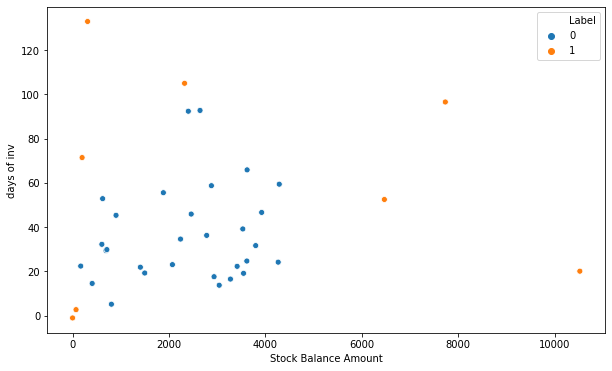

In [42]:
fig = plt.figure(figsize=  (10,6))
sns.scatterplot(x=bev['Stock Balance Amount'],y=bev['days of inv'],hue=iforest_2(bev)['Label'])
plt.show()

In [43]:
iforest_2(bev)

,Company and Cost Centre,Product Category,Stock Balance Amount,Ave Cogs - L7D,days of inv,Label,Score
5,AULS.ADL102,05_ Beverages,3041.0,220.767136,13.774695,0,-0.056619
13,AULS.ADL103,05_ Beverages,167.0,7.448428,22.420838,0,-0.073065
22,AULS.BNK101,05_ Beverages,2460.0,53.587338,45.906367,0,-0.097915
31,AULS.CNS201,05_ Beverages,3546.0,185.088802,19.158371,0,-0.104475
50,AULS.KTA101,05_ Beverages,4287.0,72.179483,59.393609,0,-0.018785
57,AULS.KTA103,05_ Beverages,1405.0,64.101947,21.918211,0,-0.114498
61,AULS.LST101,05_ Beverages,692.0,23.509577,29.434813,0,-0.112517
70,AULS.OOL101,05_ Beverages,2400.0,25.991403,92.338225,0,-0.015354
80,AULS.PER201,05_ Beverages,10524.0,523.239842,20.113147,1,0.194092
89,AULS.PER301,05_ Beverages,3922.0,84.082157,46.644855,0,-0.073885


In [48]:
# use this to query
output.SKU.unique()

array(['AULS445924', 'AULS508899', 'AULS508863', ..., 'NZDF100571700',
       'NZDF100657235', 'NZDF100802755'], dtype=object)